# Using pycisTopic on simulated melanoma data

In [1]:
import warnings
warnings.simplefilter(action='ignore')
import pycisTopic
pycisTopic.__version__

'1.0.1.dev67+gfc9b4d0'

In this tutorial we will use a precomputed matrix from 100 simulated multiome cells from melanoma, containing data from 5 lines (20 cells each) [2 mesenchymal-like cell lines and 3 melanocyte-like cell lines]. 

Data used in the tutorial is freely accessible at: https://drive.google.com/drive/u/1/folders/18ETGIKgXkILo3Xfv9KuysOMqchmSfFX2

Processed loom files are available at: https://scope.aertslab.org/#/scenic-v2

## 0. Setting up the analysis directories & common variables

The following variables are used to define the default directories to store/load data from the current notebook (any of them can be modified in the individual steps).

* **Project directory:** used as default as root directory for the notebook. In this tutorial it also contains the *input data* (e.g. fragments files, annotations...). In case the different types of files are in distinct locations, replace them individually in the required steps. 

In [2]:
# Project directory
projDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/toy_melanoma/'

* **Output directory:** to save the *results* from the analyses:

In [3]:
# Output directory
outDir = projDir + 'output/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)

* **TMP directory:** to store *temporary* files: 

In [4]:
# Temp dir
tmpDir = '/scratch/leuven/313/vsc31305/'

In this tutorial we will directly start with the generation of the cisTopic object (skipping the pseudobulk generation, consensus peak calling and QC steps), as only the accessibility count matrix is available. If you have a fragments file, please take a look to the human cerebellum or the mouse cortex tutorials.

## 1. Creating a cisTopic object

In this tutorial we will initialize the cisTopic object using a precomputed count matrix. This matrix can be provided as:

* **DataFrame**: A pandas dataframe with cells as columns and regions as rows (in UCSC format, e.g. chr1:1-500)
* **Sparse matrix**: A sparse matrix with regions as rows and cells as columns. In this case, the corresponding cell and region names must be provided as list using the parameters `cell_names` and `region_names`, respectively.

We also recommend to pass a blacklist in case blacklisted regions are included in the matrix. In addition, if fragments files are available they can be pass as dictionary using the `path_to_fragments` parameters. In this case, remember to add as metadata a column named `sample_id` indicating from which fragments file each cell is derived.

In [5]:
# Create cisTopic object
from pycisTopic.cistopic_class import *
count_matrix=pd.read_csv(projDir+'data/count_mel.tsv', sep='\t')
path_to_blacklist='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic/blacklist/hg19-blacklist.v2.bed'
cistopic_obj = create_cistopic_object(fragment_matrix=count_matrix, path_to_blacklist=path_to_blacklist)
# Adding cell information
cell_data =  pd.read_csv(projDir+'data/celldata_mel.tsv', sep='\t')
cistopic_obj.add_cell_data(cell_data)

2022-08-08 16:50:07,228 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-08-08 16:50:07,449 cisTopic     INFO     Removing blacklisted regions
2022-08-08 16:50:07,955 cisTopic     INFO     Creating CistopicObject
2022-08-08 16:50:08,190 cisTopic     INFO     Done!


Let's check the cisTopic object.

In [6]:
print(cistopic_obj)

CistopicObject from project cisTopic with n_cells × n_regions = 100 × 111299


Since we are using simulated data, we will skip the doublet detection step. Note that this step can also be run when starting from a precomputed count matrix, you can check the human cerebellum tutorial for more details.

## 2. Run models

The next step is to run the LDA models. There are two types of LDA models (with Collapsed Gibbs Sampling) you can run:

* **Serial LDA**: The parallelization is done between models rather than within each model. Recommended for small-medium sized data sets in which several models with different number of topics are being tested. You can run these models with `runCGSModels()`.
* **Parallel LDA with MALLET**: The parallelization is done within each model. Recommended for large data sets where a few models with different number of topics are being tested. If working in a cluster, we recommed to submit a job per model so they can run simultaneously. You can run it with `runCGSModelsMallet()`.

In this tutorial, we will use the Mallet. Note that the total running time will vary depending on the number of models you train, the size of the data set and the number of cores.

In [8]:
import os
path_to_mallet_binary='mallet'
# Run models
models=run_cgs_models_mallet(path_to_mallet_binary,
                    cistopic_obj,
                    n_topics=[2,5,10,15,20,25,30,35,40,45,50],
                    n_cpu=24,
                    n_iter=500, 
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    tmp_path='/scratch/leuven/313/vsc31305/', #Use SCRATCH if many models or big data set
                    save_path=None)

2022-08-08 16:50:18,529 cisTopic     INFO     Formatting input to corpus
2022-08-08 16:50:18,574 gensim.corpora.dictionary INFO     adding document #0 to Dictionary<0 unique tokens: []>
2022-08-08 16:50:19,675 gensim.corpora.dictionary INFO     built Dictionary<111299 unique tokens: ['0', '1', '2', '3', '4']...> from 100 documents (total 1116602 corpus positions)
2022-08-08 16:50:19,678 cisTopic     INFO     Running model with 2 topics
2022-08-08 16:50:19,682 LDAMalletWrapper INFO     Serializing temporary corpus to /scratch/leuven/313/vsc31305/corpus.txt
2022-08-08 16:50:22,078 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /scratch/leuven/313/vsc31305/corpus.txt --output /scratch/leuven/313/vsc31305/corpus.mallet


/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


2022-08-08 16:50:23,364 LDAMalletWrapper INFO     Training MALLET LDA with mallet train-topics --input /scratch/leuven/313/vsc31305/corpus.mallet --num-topics 2  --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 24 --output-state /scratch/leuven/313/vsc31305/58fbf1_state.mallet.gz --output-doc-topics /scratch/leuven/313/vsc31305/58fbf1_doctopics.txt --output-topic-keys /scratch/leuven/313/vsc31305/58fbf1_topickeys.txt --num-iterations 500 --inferencer-filename /scratch/leuven/313/vsc31305/58fbf1_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 555
2022-08-08 16:50:46,801 LDAMalletWrapper INFO     loading assigned topics from /scratch/leuven/313/vsc31305/58fbf1_state.mallet.gz
2022-08-08 16:50:51,729 cisTopic     INFO     Model with 2 topics done!
2022-08-08 16:50:51,731 cisTopic     INFO     Running model with 5 topics
2022-08-08 16:50:51,736 LDAMalletWrapper INFO     Serializing temporary corpus to /scratch/leuven/313/vsc31305/corpus.txt
2022-08-08 16:50:54,212 LDAM

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


2022-08-08 16:50:55,239 LDAMalletWrapper INFO     Training MALLET LDA with mallet train-topics --input /scratch/leuven/313/vsc31305/corpus.mallet --num-topics 5  --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 24 --output-state /scratch/leuven/313/vsc31305/34861d_state.mallet.gz --output-doc-topics /scratch/leuven/313/vsc31305/34861d_doctopics.txt --output-topic-keys /scratch/leuven/313/vsc31305/34861d_topickeys.txt --num-iterations 500 --inferencer-filename /scratch/leuven/313/vsc31305/34861d_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 555
2022-08-08 16:51:22,202 LDAMalletWrapper INFO     loading assigned topics from /scratch/leuven/313/vsc31305/34861d_state.mallet.gz
2022-08-08 16:51:27,216 cisTopic     INFO     Model with 5 topics done!
2022-08-08 16:51:27,218 cisTopic     INFO     Running model with 10 topics
2022-08-08 16:51:27,223 LDAMalletWrapper INFO     Serializing temporary corpus to /scratch/leuven/313/vsc31305/corpus.txt
2022-08-08 16:51:29,631 LDA

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


2022-08-08 16:51:30,691 LDAMalletWrapper INFO     Training MALLET LDA with mallet train-topics --input /scratch/leuven/313/vsc31305/corpus.mallet --num-topics 10  --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 24 --output-state /scratch/leuven/313/vsc31305/c7e237_state.mallet.gz --output-doc-topics /scratch/leuven/313/vsc31305/c7e237_doctopics.txt --output-topic-keys /scratch/leuven/313/vsc31305/c7e237_topickeys.txt --num-iterations 500 --inferencer-filename /scratch/leuven/313/vsc31305/c7e237_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 555
2022-08-08 16:51:56,065 LDAMalletWrapper INFO     loading assigned topics from /scratch/leuven/313/vsc31305/c7e237_state.mallet.gz
2022-08-08 16:52:01,461 cisTopic     INFO     Model with 10 topics done!
2022-08-08 16:52:01,463 cisTopic     INFO     Running model with 15 topics
2022-08-08 16:52:01,468 LDAMalletWrapper INFO     Serializing temporary corpus to /scratch/leuven/313/vsc31305/corpus.txt
2022-08-08 16:52:03,865 L

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


2022-08-08 16:52:04,937 LDAMalletWrapper INFO     Training MALLET LDA with mallet train-topics --input /scratch/leuven/313/vsc31305/corpus.mallet --num-topics 15  --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 24 --output-state /scratch/leuven/313/vsc31305/c8058f_state.mallet.gz --output-doc-topics /scratch/leuven/313/vsc31305/c8058f_doctopics.txt --output-topic-keys /scratch/leuven/313/vsc31305/c8058f_topickeys.txt --num-iterations 500 --inferencer-filename /scratch/leuven/313/vsc31305/c8058f_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 555
2022-08-08 16:52:34,683 LDAMalletWrapper INFO     loading assigned topics from /scratch/leuven/313/vsc31305/c8058f_state.mallet.gz
2022-08-08 16:52:40,361 cisTopic     INFO     Model with 15 topics done!
2022-08-08 16:52:40,363 cisTopic     INFO     Running model with 20 topics
2022-08-08 16:52:40,368 LDAMalletWrapper INFO     Serializing temporary corpus to /scratch/leuven/313/vsc31305/corpus.txt
2022-08-08 16:52:42,849 L

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


2022-08-08 16:52:43,932 LDAMalletWrapper INFO     Training MALLET LDA with mallet train-topics --input /scratch/leuven/313/vsc31305/corpus.mallet --num-topics 20  --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 24 --output-state /scratch/leuven/313/vsc31305/4eedfc_state.mallet.gz --output-doc-topics /scratch/leuven/313/vsc31305/4eedfc_doctopics.txt --output-topic-keys /scratch/leuven/313/vsc31305/4eedfc_topickeys.txt --num-iterations 500 --inferencer-filename /scratch/leuven/313/vsc31305/4eedfc_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 555
2022-08-08 16:53:15,498 LDAMalletWrapper INFO     loading assigned topics from /scratch/leuven/313/vsc31305/4eedfc_state.mallet.gz
2022-08-08 16:53:21,588 cisTopic     INFO     Model with 20 topics done!
2022-08-08 16:53:21,590 cisTopic     INFO     Running model with 25 topics
2022-08-08 16:53:21,594 LDAMalletWrapper INFO     Serializing temporary corpus to /scratch/leuven/313/vsc31305/corpus.txt
2022-08-08 16:53:24,095 L

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


2022-08-08 16:53:25,235 LDAMalletWrapper INFO     Training MALLET LDA with mallet train-topics --input /scratch/leuven/313/vsc31305/corpus.mallet --num-topics 25  --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 24 --output-state /scratch/leuven/313/vsc31305/9a893_state.mallet.gz --output-doc-topics /scratch/leuven/313/vsc31305/9a893_doctopics.txt --output-topic-keys /scratch/leuven/313/vsc31305/9a893_topickeys.txt --num-iterations 500 --inferencer-filename /scratch/leuven/313/vsc31305/9a893_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 555
2022-08-08 16:53:55,887 LDAMalletWrapper INFO     loading assigned topics from /scratch/leuven/313/vsc31305/9a893_state.mallet.gz
2022-08-08 16:54:02,576 cisTopic     INFO     Model with 25 topics done!
2022-08-08 16:54:02,579 cisTopic     INFO     Running model with 30 topics
2022-08-08 16:54:02,586 LDAMalletWrapper INFO     Serializing temporary corpus to /scratch/leuven/313/vsc31305/corpus.txt
2022-08-08 16:54:05,224 LDAMal

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


2022-08-08 16:54:06,360 LDAMalletWrapper INFO     Training MALLET LDA with mallet train-topics --input /scratch/leuven/313/vsc31305/corpus.mallet --num-topics 30  --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 24 --output-state /scratch/leuven/313/vsc31305/b93f0_state.mallet.gz --output-doc-topics /scratch/leuven/313/vsc31305/b93f0_doctopics.txt --output-topic-keys /scratch/leuven/313/vsc31305/b93f0_topickeys.txt --num-iterations 500 --inferencer-filename /scratch/leuven/313/vsc31305/b93f0_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 555
2022-08-08 16:54:35,739 LDAMalletWrapper INFO     loading assigned topics from /scratch/leuven/313/vsc31305/b93f0_state.mallet.gz
2022-08-08 16:54:42,680 cisTopic     INFO     Model with 30 topics done!
2022-08-08 16:54:42,683 cisTopic     INFO     Running model with 35 topics
2022-08-08 16:54:42,689 LDAMalletWrapper INFO     Serializing temporary corpus to /scratch/leuven/313/vsc31305/corpus.txt
2022-08-08 16:54:45,238 LDAMal

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


2022-08-08 16:54:46,413 LDAMalletWrapper INFO     Training MALLET LDA with mallet train-topics --input /scratch/leuven/313/vsc31305/corpus.mallet --num-topics 35  --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 24 --output-state /scratch/leuven/313/vsc31305/cd8dae_state.mallet.gz --output-doc-topics /scratch/leuven/313/vsc31305/cd8dae_doctopics.txt --output-topic-keys /scratch/leuven/313/vsc31305/cd8dae_topickeys.txt --num-iterations 500 --inferencer-filename /scratch/leuven/313/vsc31305/cd8dae_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 555
2022-08-08 16:55:16,720 LDAMalletWrapper INFO     loading assigned topics from /scratch/leuven/313/vsc31305/cd8dae_state.mallet.gz
2022-08-08 16:55:24,232 cisTopic     INFO     Model with 35 topics done!
2022-08-08 16:55:24,234 cisTopic     INFO     Running model with 40 topics
2022-08-08 16:55:24,240 LDAMalletWrapper INFO     Serializing temporary corpus to /scratch/leuven/313/vsc31305/corpus.txt
2022-08-08 16:55:26,704 L

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


2022-08-08 16:55:27,824 LDAMalletWrapper INFO     Training MALLET LDA with mallet train-topics --input /scratch/leuven/313/vsc31305/corpus.mallet --num-topics 40  --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 24 --output-state /scratch/leuven/313/vsc31305/df9c93_state.mallet.gz --output-doc-topics /scratch/leuven/313/vsc31305/df9c93_doctopics.txt --output-topic-keys /scratch/leuven/313/vsc31305/df9c93_topickeys.txt --num-iterations 500 --inferencer-filename /scratch/leuven/313/vsc31305/df9c93_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 555
2022-08-08 16:56:00,013 LDAMalletWrapper INFO     loading assigned topics from /scratch/leuven/313/vsc31305/df9c93_state.mallet.gz
2022-08-08 16:56:07,750 cisTopic     INFO     Model with 40 topics done!
2022-08-08 16:56:07,752 cisTopic     INFO     Running model with 45 topics
2022-08-08 16:56:07,758 LDAMalletWrapper INFO     Serializing temporary corpus to /scratch/leuven/313/vsc31305/corpus.txt
2022-08-08 16:56:10,274 L

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


2022-08-08 16:56:11,403 LDAMalletWrapper INFO     Training MALLET LDA with mallet train-topics --input /scratch/leuven/313/vsc31305/corpus.mallet --num-topics 45  --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 24 --output-state /scratch/leuven/313/vsc31305/c1337b_state.mallet.gz --output-doc-topics /scratch/leuven/313/vsc31305/c1337b_doctopics.txt --output-topic-keys /scratch/leuven/313/vsc31305/c1337b_topickeys.txt --num-iterations 500 --inferencer-filename /scratch/leuven/313/vsc31305/c1337b_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 555
2022-08-08 16:56:41,948 LDAMalletWrapper INFO     loading assigned topics from /scratch/leuven/313/vsc31305/c1337b_state.mallet.gz
2022-08-08 16:56:50,186 cisTopic     INFO     Model with 45 topics done!
2022-08-08 16:56:50,193 cisTopic     INFO     Running model with 50 topics
2022-08-08 16:56:50,199 LDAMalletWrapper INFO     Serializing temporary corpus to /scratch/leuven/313/vsc31305/corpus.txt
2022-08-08 16:56:52,737 L

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


2022-08-08 16:56:53,875 LDAMalletWrapper INFO     Training MALLET LDA with mallet train-topics --input /scratch/leuven/313/vsc31305/corpus.mallet --num-topics 50  --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 24 --output-state /scratch/leuven/313/vsc31305/ffacfd_state.mallet.gz --output-doc-topics /scratch/leuven/313/vsc31305/ffacfd_doctopics.txt --output-topic-keys /scratch/leuven/313/vsc31305/ffacfd_topickeys.txt --num-iterations 500 --inferencer-filename /scratch/leuven/313/vsc31305/ffacfd_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 555
2022-08-08 16:57:25,551 LDAMalletWrapper INFO     loading assigned topics from /scratch/leuven/313/vsc31305/ffacfd_state.mallet.gz
2022-08-08 16:57:34,398 cisTopic     INFO     Model with 50 topics done!


In [9]:
# Save
import pickle 
with open(outDir+'Mallet_models_500.pkl', 'wb') as f:
  pickle.dump(models, f)

## 3. Model selection

There are several methods that can be used for model selection:

* **Minmo_2011**: Uses the average model coherence as calculated by Mimno et al (2011). In order to reduce the impact of the number of topics, we calculate the average coherence based on the top selected average values. The better the model, the higher coherence.
* **Log-likelihood**: Uses the log-likelihood in the last iteration as calculated by Griffiths and Steyvers (2004). The better the model, the higher the log-likelihood.
* **Arun_2010**: Uses a density-based metric as in Arun et al (2010) using the topic-region distribution, the cell-topic distribution and the cell coverage. The better the model, the lower the metric.
* **Cao_Juan_2009**: Uses a divergence-based metric as in Cao Juan et al (2009) using the topic-region distribution. The better the model, the lower the metric.

For scATAC-seq data models, the most helpful methods are Minmo (topic coherence) and the log-likelihood in the last iteration.

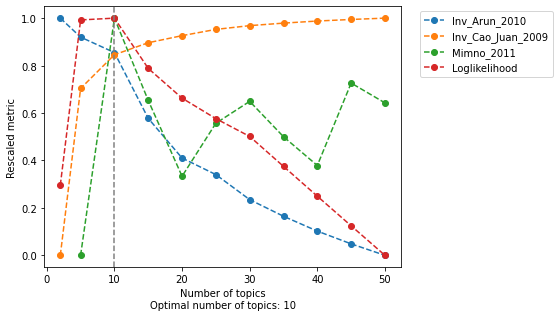

In [10]:
#os.mkdir(outDir+'models')
model=evaluate_models(models,
                     select_model=None, 
                     return_model=True, 
                     metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics=False,
                     save= outDir + 'models/model_selection.pdf')

In [11]:
# Add model to cisTopicObject
cistopic_obj.add_LDA_model(model)

In [12]:
# Save
with open(outDir + 'toy_melanoma_cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

## 4. Clustering and visualization

We can cluster the cells (or regions) using the leiden algorithm, and perform dimensionality reductiion with UMAP and TSNE. In these examples we will focus on the cells only. For these steps, the cell-topic contriibutions of the model will be used.

In [5]:
# Load cisTopic object
import pickle
infile = open(outDir + 'toy_melanoma_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [14]:
from pycisTopic.clust_vis import *
find_clusters(cistopic_obj,
                 target  = 'cell',
                 k = 10,
                 res = [0.6], 
                 prefix = 'pycisTopic_', 
                 scale = True,
                 split_pattern = '-')

2022-08-08 16:58:08,160 cisTopic     INFO     Finding neighbours


In [15]:
run_umap(cistopic_obj,
                 target  = 'cell', scale=True)

2022-08-08 16:58:10,231 cisTopic     INFO     Running UMAP


In [16]:
run_tsne(cistopic_obj,
                 target  = 'cell', scale=True)

2022-08-08 16:58:17,730 cisTopic     INFO     Running FItSNE
Will use momentum during exaggeration phase
Computing input similarities...
Using perplexity, so normalizing input data (to prevent numerical problems)
Using perplexity, not the manually set kernel width.  K (number of nearest neighbors) and sigma (bandwidth) parameters are going to be ignored.
Using ANNOY for knn search, with parameters: n_trees 50 and search_k 4500
Going to allocate memory. N: 100, K: 90, N*K = 9000
Building Annoy tree...
Done building tree. Beginning nearest neighbor search... 
parallel (36 threads):


The clustering assignments are added to `cistopic_obj.cell_data` and the projections to `cistopic_obj.projections['cell']`. If you would like to add additional dimensionality reductions, you can just add them as an entry to the projections dictionary (under 'cell' in this case).

We can also visualize metadata (categorical or continuous) on the UMAP/tSNE spaces.

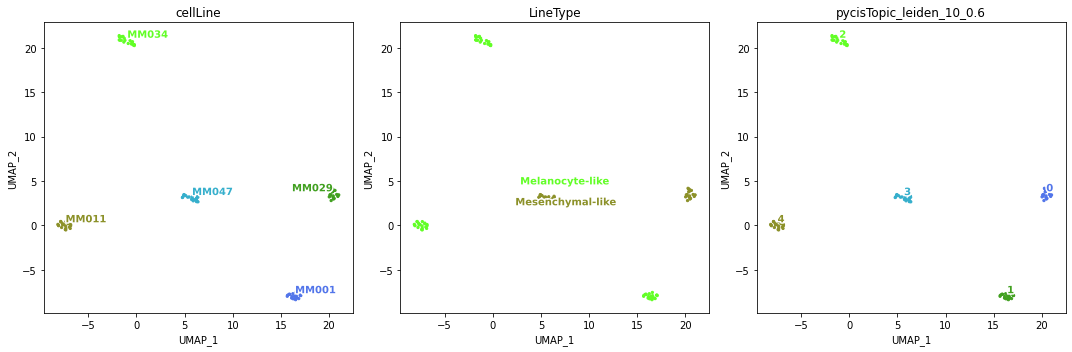

In [17]:
os.mkdir(outDir+'/visualization')
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['cellLine', 'LineType', 'pycisTopic_leiden_10_0.6'], # Labels from RNA and new clusters
                 target='cell', num_columns=3,
                 text_size=10,
                 dot_size=5,
                 figsize=(15,5),
                 save= outDir + 'visualization/dimensionality_reduction_label.pdf')

In [8]:
annot_dict={}
annot_dict['pycisTopic_leiden_10_0.6'] = {'0':'MM029 (0)', '1':'MM001 (1)', '2': 'MM034 (2)', '3': 'MM047 (3)', '4': 'MM011 (4)'}
cistopic_obj.cell_data['pycisTopic_leiden_10_0.6'] = [annot_dict['pycisTopic_leiden_10_0.6'][x] for x in cistopic_obj.cell_data['pycisTopic_leiden_10_0.6'].tolist()]

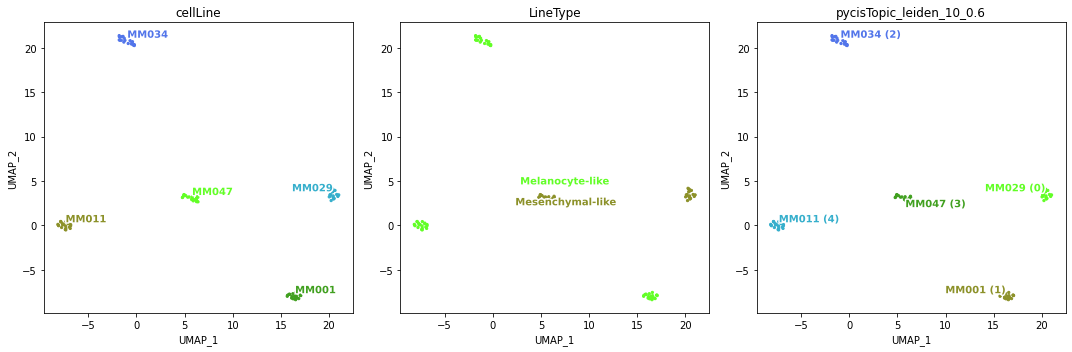

In [9]:
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['cellLine', 'LineType', 'pycisTopic_leiden_10_0.6'], # Labels from RNA and new clusters
                 target='cell', num_columns=3,
                 text_size=10,
                 dot_size=5,
                 figsize=(15,5),
                 save= outDir + 'visualization/dimensionality_reduction_label.pdf')

We can also plot the topic-contributions.

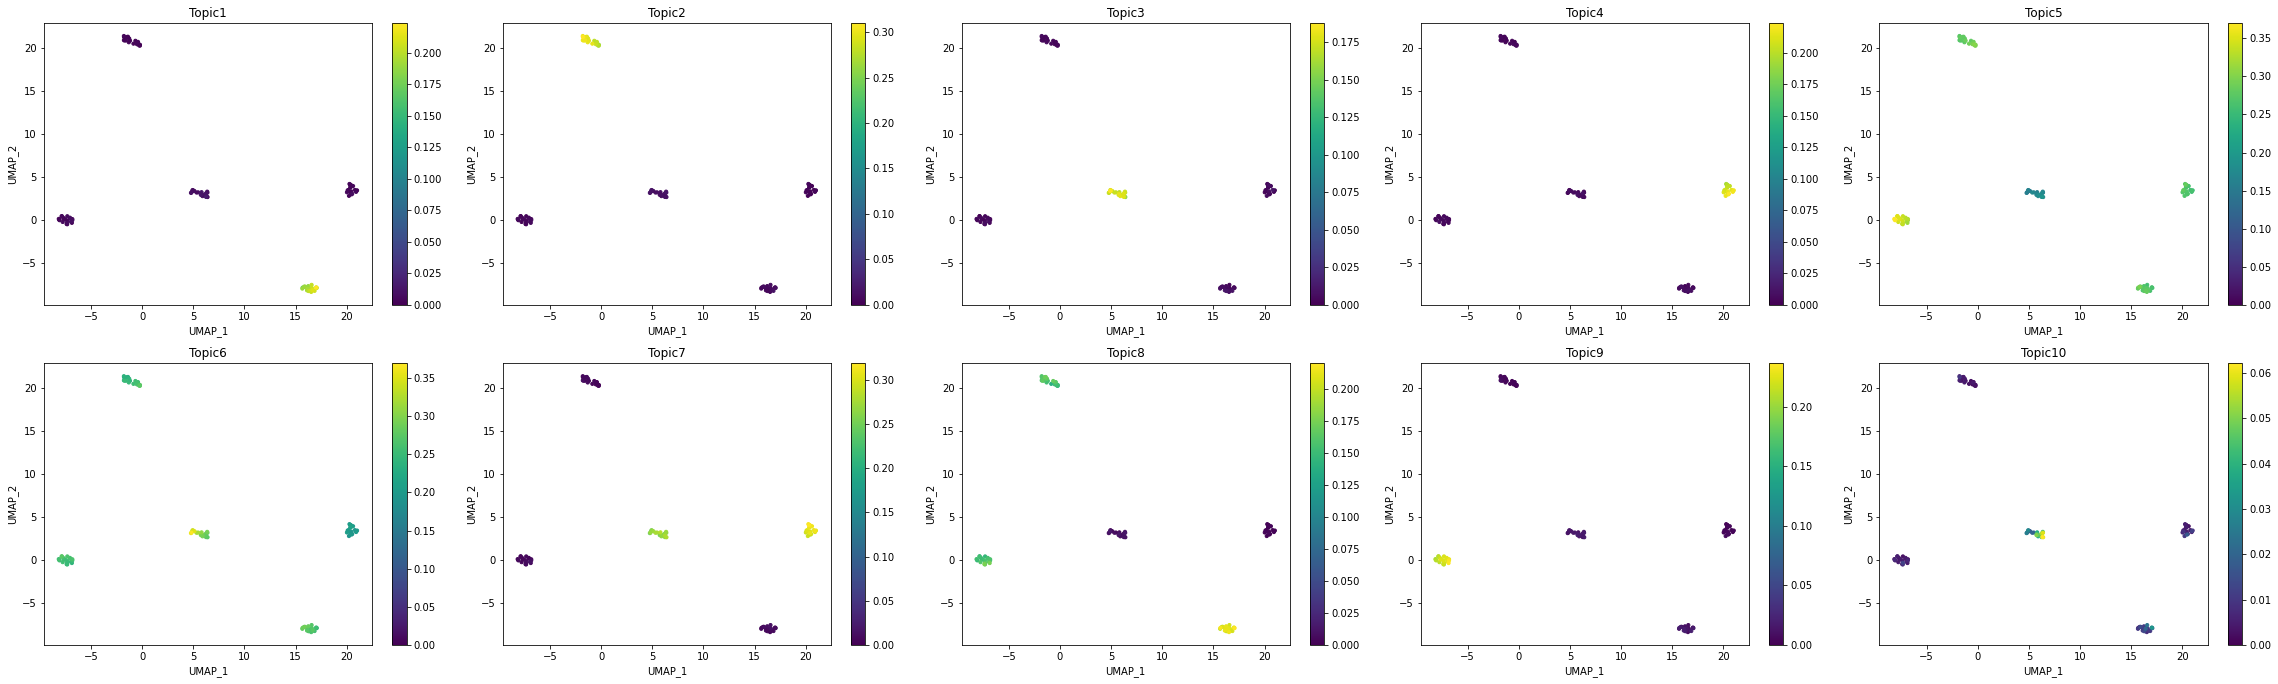

In [19]:
plot_topic(cistopic_obj,
            reduction_name = 'UMAP',
            target = 'cell',
            num_columns=5,
            save= outDir + 'visualization/dimensionality_reduction_topic_contr.pdf')

Or we can also draw a heatmap with the topic contributions (and annotations).

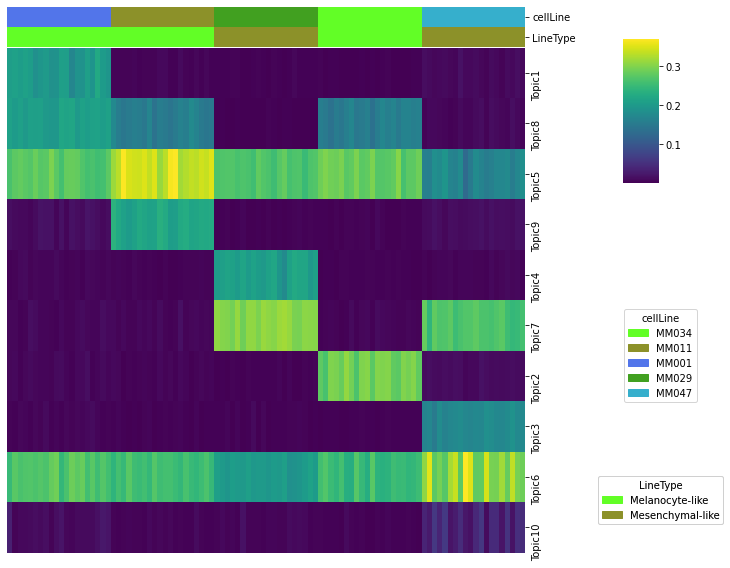

In [24]:
cell_topic_heatmap(cistopic_obj,
                     variables = ['cellLine', 'LineType'],
                     scale = False,
                     legend_loc_x = 1.05,
                     legend_loc_y = -1.2,
                     legend_dist_y = -1,
                     figsize=(10,10),
                     save = outDir + 'visualization/heatmap_topic_contr.pdf')

In [25]:
# Save
with open(outDir + 'toy_melanoma_cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

## 5. Topic binarization & qc

Next we can binarize topic-region and cell-topic distributions. The first is useful for exploring the topics with other tools that work with region sets (e.g. GREAT, cisTarget); while the latter is useful to automatically automate topics.

In [26]:
# Load cisTopic object
import pickle
infile = open(outDir + 'toy_melanoma_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

We will first binarize the topic-region distributions. There are several methods that can be used for this: 'otsu' (Otsu, 1979), 'yen' (Yen et al., 1995), 'li'
(Li & Lee, 1993), 'aucell' (Van de Sande et al., 2020) or 'ntop' (Taking the top n regions per topic). Otsu and Yen's methods work well in topic-region distributions; however for some downstream analyses it may be convenient to use 'ntop' to have balanced region sets.

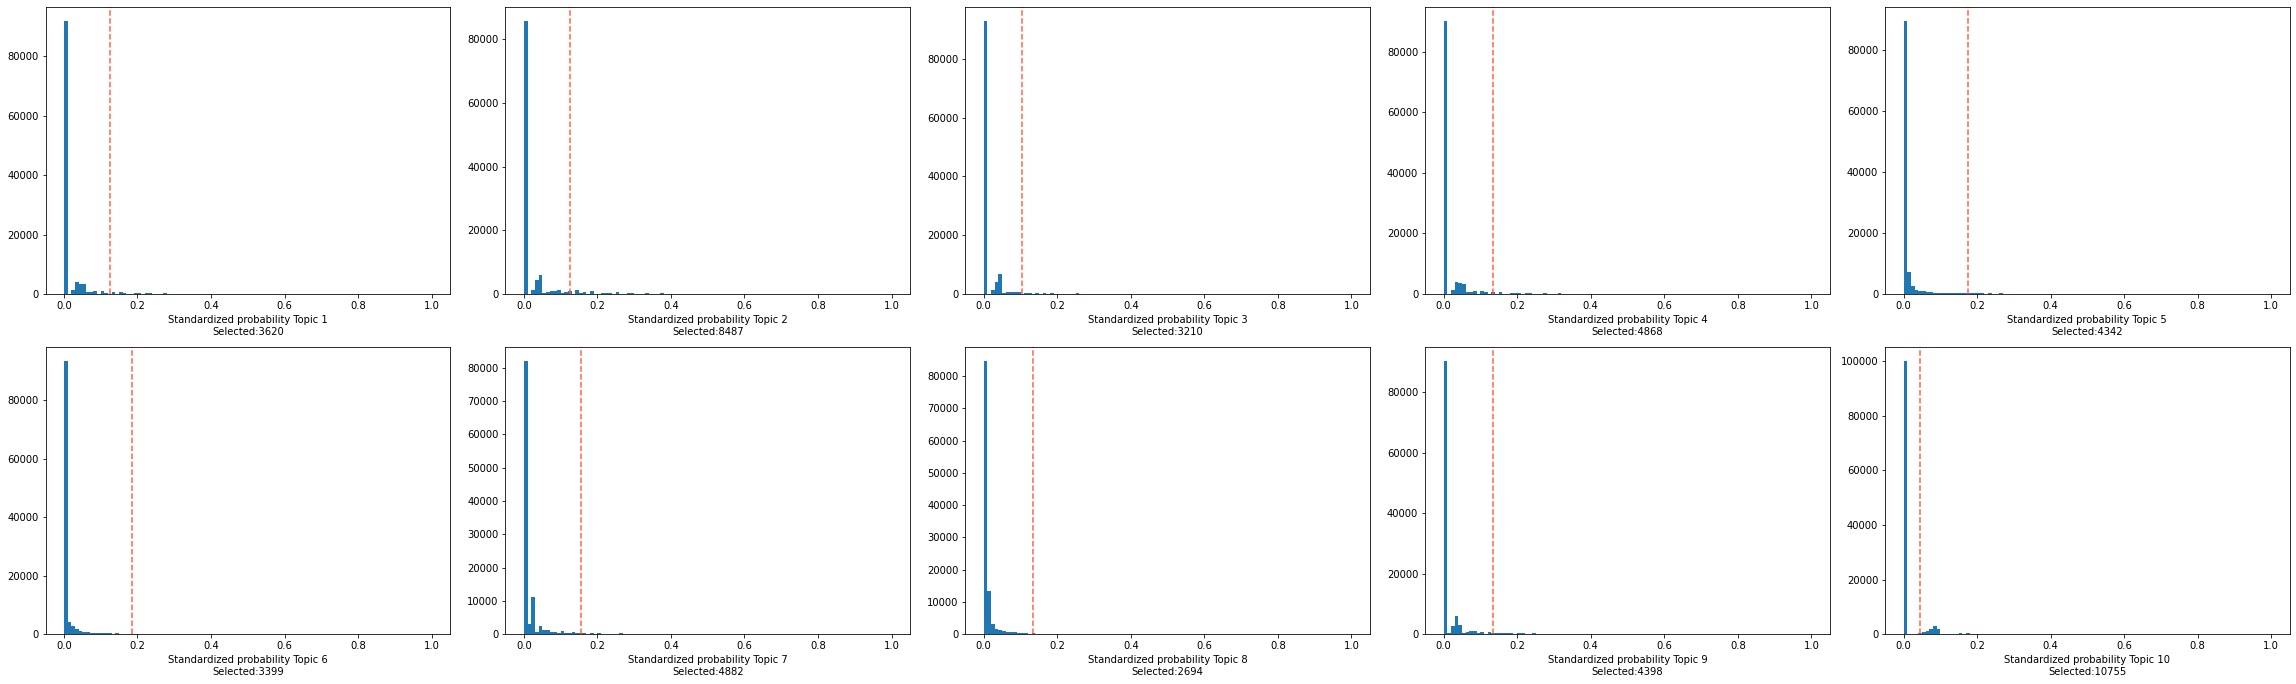

In [27]:
os.mkdir(outDir+'topic_binarization')
from pycisTopic.topic_binarization import *
region_bin_topics = binarize_topics(cistopic_obj, method='otsu', ntop=3000, plot=True, num_columns=5, save= outDir + 'topic_binarization/otsu.pdf')

Similarly, we can now binarize the cell-topic distribions. 

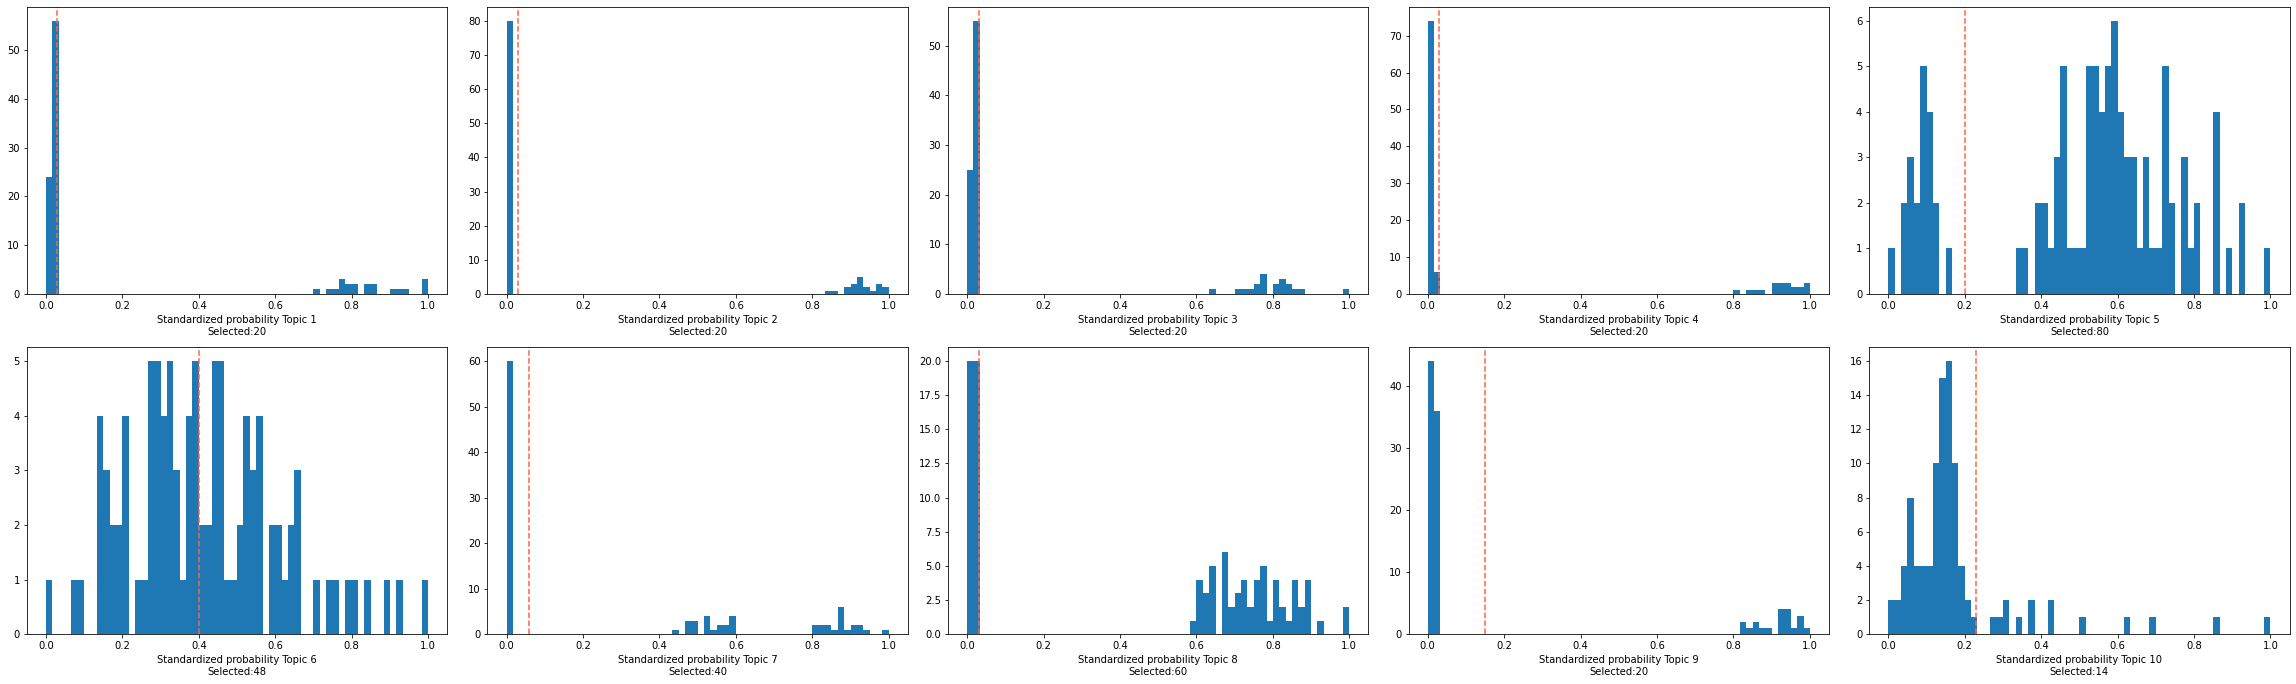

In [34]:
binarized_cell_topic = binarize_topics(cistopic_obj, target='cell', method='li', plot=True, num_columns=5, nbins=60)

Following, we can compute the topic quality control metrics. These include:

* **Number of assignments**
* **Topic coherence (Mimno et al., 2011)**: Measures to which extent high scoring regions in the topic are actually co-accessible in the original data. If it is low it indicates that the topic is rather random. The higher, the better is a topic. 
* **The marginal topic distribution**: Indicates how much each topic contributes to the model. The higher, the better is a topic.
* **The gini index**: Value between 0 and 1, that indicates the specificity of topics (0: General, 1:Specific)
* If topics have been binarized, the number of regions/cells per topic will be added.

In [35]:
from pycisTopic.topic_qc import *
topic_qc_metrics = compute_topic_metrics(cistopic_obj)

We will create a figure dictionary to put all plots together. In this case, we will not put any threshold to filter topics.

In [36]:
fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)

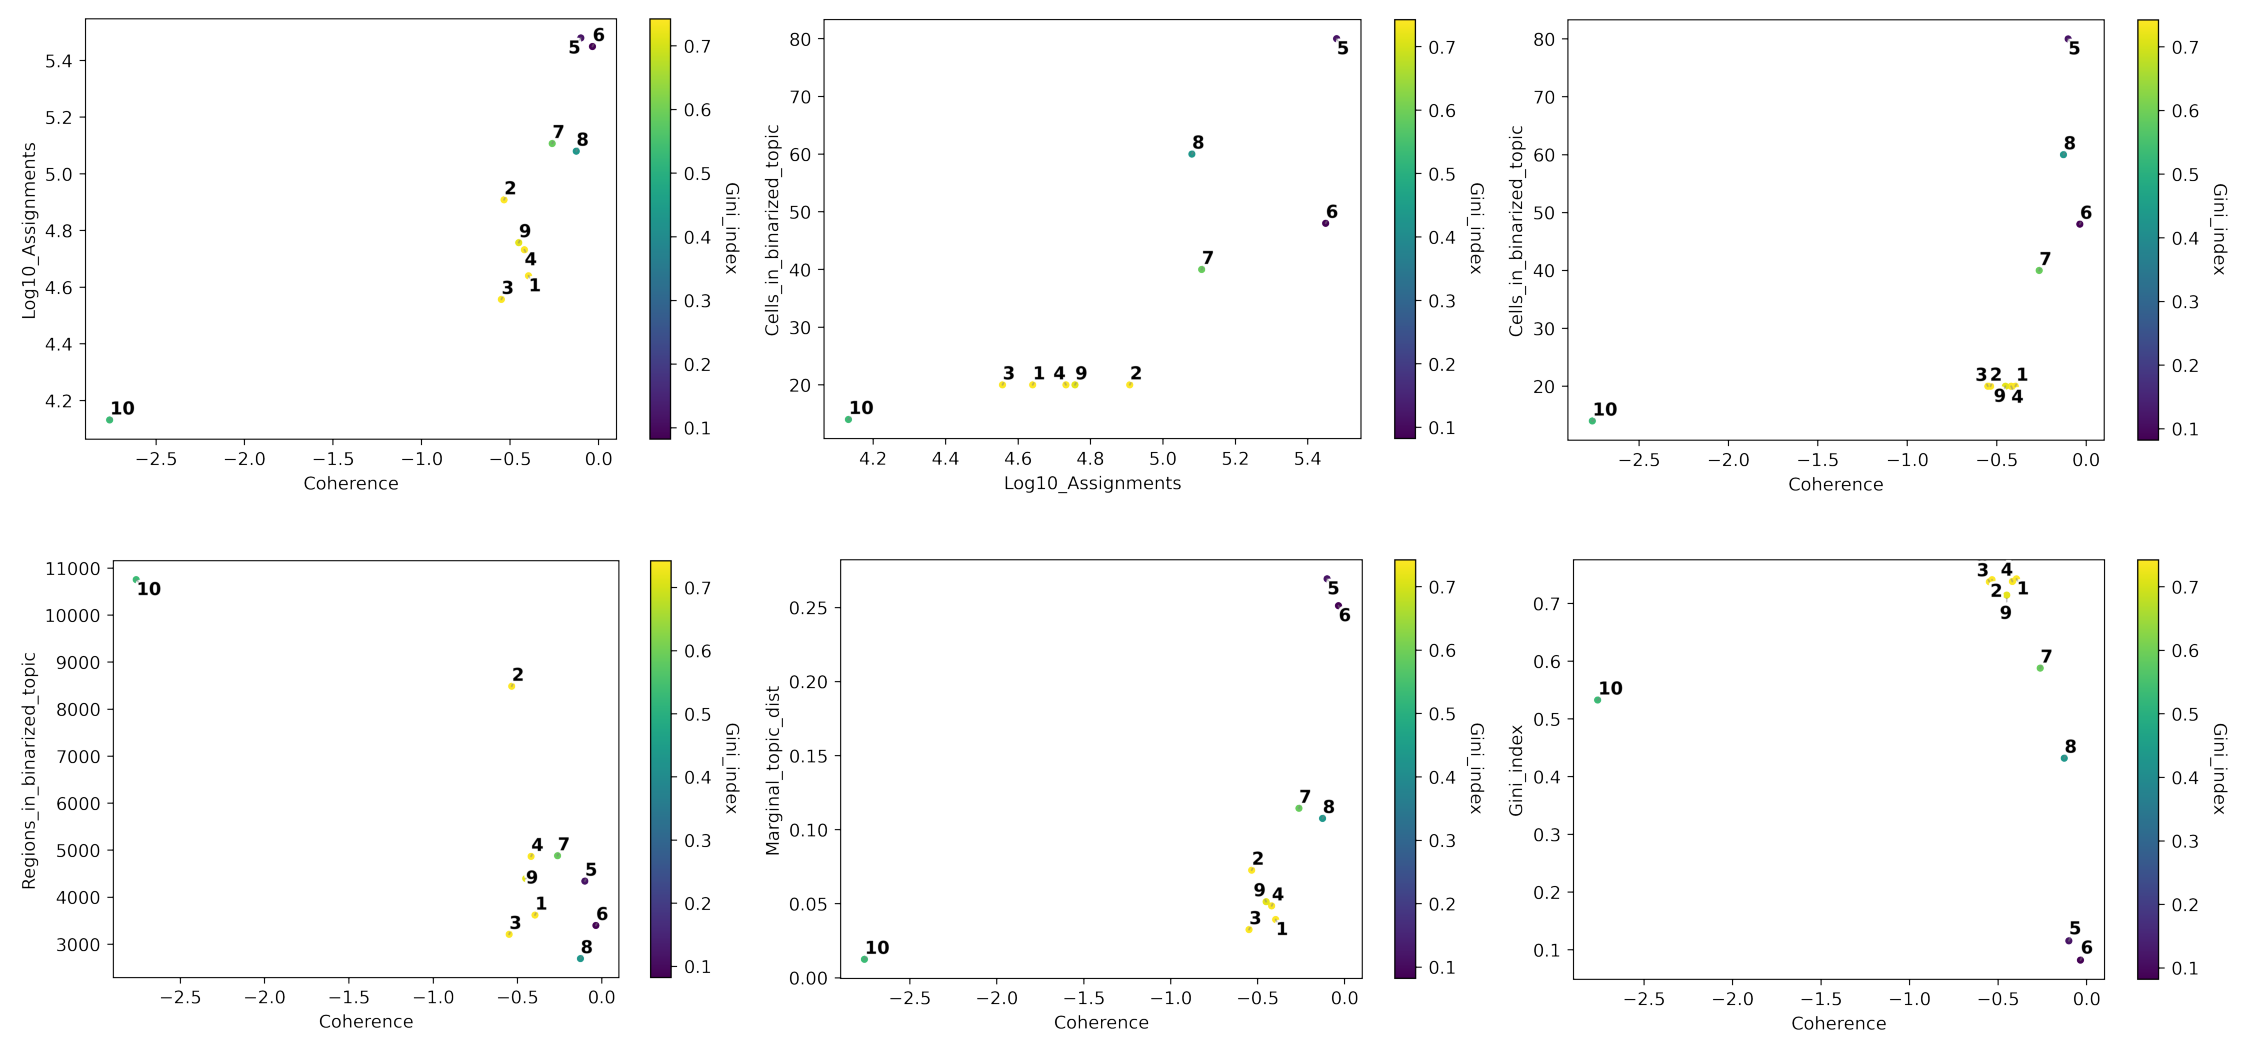

In [37]:
# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
fig.savefig(outDir + 'topic_binarization/Topic_qc.pdf', bbox_inches='tight')
plt.show()

Topic 7 (Mesenchymal-like) is an example of a good topic: it has a high coherence and a high number of assignmnents/marginal topic score (these measurements are correlated), while being cell type specific (with a high gini index). Generally, we will consider a topic as bad if it has a low number of assignments while being assigned to many cells and a low coherence. 

Next, we can automatically annotate topics, in this case by cell type. Here we calculate the proportion of cells in each group that are assigned to the binarized topic in comparison to the ratio in the whole data set. We will consider a topic as general if the difference between the ration of cells in the whole data set in the binarized topic and the ratio of total cells in the assigned groups is above 0.2. This indicates that the topic is general, and the propotion test may fail if the topic is enriched in both foreground (the group) and background (the whole data set); resulting in a big difference between the ratios.

In [48]:
topic_annot = topic_annotation(cistopic_obj, annot_var='cellLine', binarized_cell_topic=binarized_cell_topic, general_topic_thr = 0.2)

In [49]:
topic_annot

,cellLine,Ratio_cells_in_topic,Ratio_group_in_population,is_general
Topic1,MM001,0.2,0.2,False
Topic2,MM034,0.2,0.2,False
Topic3,MM047,0.2,0.2,False
Topic4,MM029,0.2,0.2,False
Topic5,"MM034, MM011, MM001, MM029",0.8,0.8,False
Topic6,"MM034, MM011",0.48,0.4,False
Topic7,"MM029, MM047",0.4,0.4,False
Topic8,"MM034, MM011, MM001",0.6,0.6,False
Topic9,MM011,0.2,0.2,False
Topic10,MM047,0.14,0.2,False


We can merge the topic metrics and their annotation in a data frame.

In [51]:
topic_qc_metrics = pd.concat([topic_annot[['cellLine', 'Ratio_cells_in_topic', 'Ratio_group_in_population']], topic_qc_metrics], axis=1)

In [52]:
topic_qc_metrics

,cellLine,Ratio_cells_in_topic,Ratio_group_in_population,Log10_Assignments,Assignments,Regions_in_binarized_topic,Cells_in_binarized_topic,Coherence,Marginal_topic_dist,Gini_index
Topic1,MM001,0.2,0.2,4.640322,43684.0,3620,20,-0.396362,0.039375,0.742580
Topic2,MM034,0.2,0.2,4.908346,80974.0,8487,20,-0.534409,0.072682,0.741149
Topic3,MM047,0.2,0.2,4.556990,36057.0,3210,20,-0.549575,0.032570,0.737557
Topic4,MM029,0.2,0.2,4.732201,53976.0,4868,20,-0.419474,0.048585,0.737999
Topic5,"MM034, MM011, MM001, MM029",0.8,0.8,5.479564,301692.0,4342,80,-0.100639,0.269443,0.115635
Topic6,"MM034, MM011",0.48,0.4,5.449272,281366.0,3399,48,-0.035105,0.251285,0.082241
Topic7,"MM029, MM047",0.4,0.4,5.106959,127926.0,4882,40,-0.262442,0.114487,0.587996
Topic8,"MM034, MM011, MM001",0.6,0.6,5.079962,120216.0,2694,60,-0.126691,0.107635,0.431982
Topic9,MM011,0.2,0.2,4.757168,57170.0,4398,20,-0.451291,0.051422,0.714474
Topic10,MM047,0.14,0.2,4.131651,13541.0,10755,14,-2.761674,0.012516,0.532736


In [53]:
# Save
with open(outDir + 'topic_binarization/Topic_qc_metrics_annot.pkl', 'wb') as f:
  pickle.dump(topic_qc_metrics, f)
with open(outDir + 'topic_binarization/binarized_cell_topic.pkl', 'wb') as f:
  pickle.dump(binarized_cell_topic, f)
with open(outDir + 'topic_binarization/binarized_topic_region.pkl', 'wb') as f:
  pickle.dump(region_bin_topics, f)

## 6. Differentially Accessible Regions (DARs)

In [55]:
# Load cisTopic object
import pickle
infile = open(outDir + 'toy_melanoma_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

Together with working with regulatory topics, we can also identify differentially accessible regions (DARs) between cell types. First, we will impute the region accessibility exploting the cell-topic and topic-region probabilities. To shrink very low probability values to 0, we use a scale factor (by default: 10^6).

In [56]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)

2022-08-08 17:07:40,974 cisTopic     INFO     Imputing drop-outs
2022-08-08 17:07:41,114 cisTopic     INFO     Scaling
2022-08-08 17:07:41,145 cisTopic     INFO     Keep non zero rows
2022-08-08 17:07:41,216 cisTopic     INFO     Imputed accessibility sparsity: 0.3654055292500382
2022-08-08 17:07:41,217 cisTopic     INFO     Create CistopicImputedFeatures object
2022-08-08 17:07:41,217 cisTopic     INFO     Done!


Next we will log-normalize the imputed data.

In [57]:
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2022-08-08 17:07:43,446 cisTopic     INFO     Normalizing imputed data
2022-08-08 17:07:43,699 cisTopic     INFO     Done!


Optionally, we can identify highly variable regions. This is not mandatory, but will speed up the hypothesis testing step for identifying DARs.

2022-08-08 17:07:45,380 cisTopic     INFO     Calculating mean
2022-08-08 17:07:45,400 cisTopic     INFO     Calculating variance


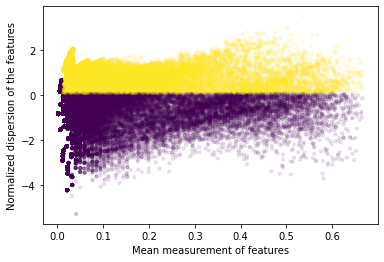

2022-08-08 17:07:57,253 cisTopic     INFO     Done!


In [58]:
os.mkdir(outDir+'DARs')
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj,
                                           min_disp = 0.05,
                                           min_mean = 0.0125, 
                                           max_mean = 3,
                                           max_disp = np.inf,
                                           n_bins=20, 
                                           n_top_features=None,
                                           plot=True,
                                           save= outDir + 'DARs/HVR_plot.pdf')

There is a total of 47,856 variable features.

In [59]:
len(variable_regions)

47856

We can now identify differentially accessible regions between groups. By default, this function will perform a Wilcoxon rank-sum test between each group in the specified variable and the rest. Alternatively, specified contrast can be provided as a list with foreground and background groups (e.g. for group 1 versus group 2 and 3, and group 2 versus group 1 and 3: [[['Group_1'], ['Group_2, 'Group_3']], [['Group_2'], ['Group_1, 'Group_3']]]).

In [60]:
markers_dict= find_diff_features(cistopic_obj, 
                      imputed_acc_obj,
                      variable='cellLine',
                      var_features=variable_regions,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=5,
                      _temp_dir=tmpDir + 'ray_spill',
                      split_pattern = '-') 

2022-08-08 17:08:17,367	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=22995) 2022-08-08 17:08:20,937 cisTopic     INFO     Formatting data for MM034
(markers_ray pid=22994) 2022-08-08 17:08:20,895 cisTopic     INFO     Formatting data for MM011
(markers_ray pid=22994) 2022-08-08 17:08:20,936 cisTopic     INFO     Computing p-value for MM011
(markers_ray pid=22998) 2022-08-08 17:08:20,907 cisTopic     INFO     Formatting data for MM029
(markers_ray pid=22998) 2022-08-08 17:08:20,957 cisTopic     INFO     Computing p-value for MM029
(markers_ray pid=22996) 2022-08-08 17:08:20,898 cisTopic     INFO     Formatting data for MM001
(markers_ray pid=22996) 2022-08-08 17:08:20,952 cisTopic     INFO     Computing p-value for MM001
(markers_ray pid=22995) 2022-08-08 17:08:20,983 cisTopic     INFO     Computing p-value for MM034
(markers_ray pid=22997) 2022-08-08 17:08:20,970 cisTopic     INFO     Formatting data for MM047
(markers_ray pid=22997) 2022-08-08 17:08:21,014 cisTopic     INFO     Computing p-value for MM047
(markers_ray pid=22997) 2022-0

We can also plot region accessibility into the cell-topic UMAP. For example, let's check how the best DARs for some cell types look like.

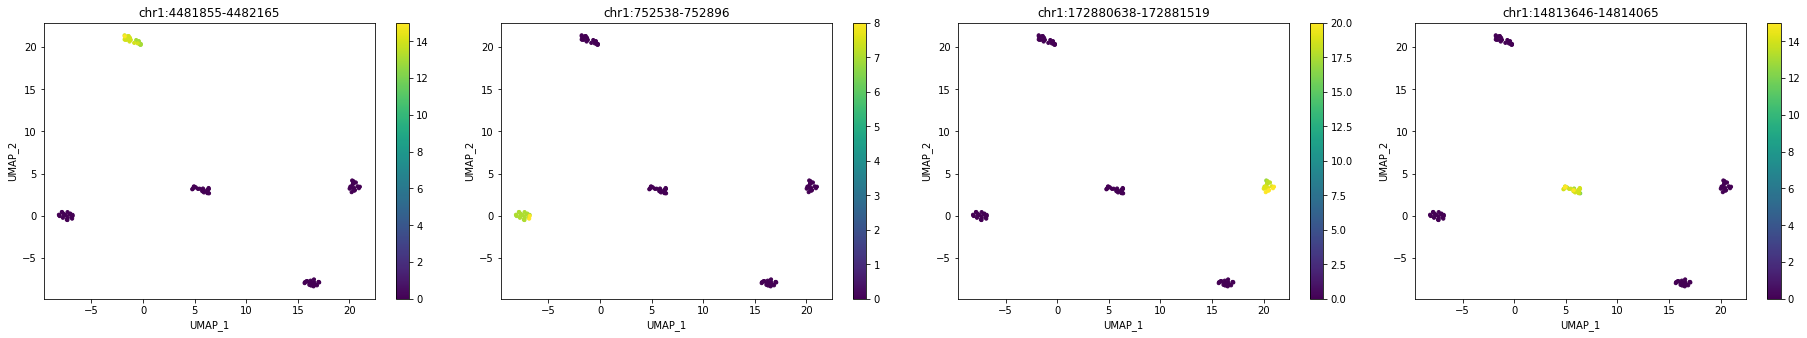

In [61]:
from pycisTopic.clust_vis import *
plot_imputed_features(cistopic_obj,
                    reduction_name='UMAP',
                    imputed_data=imputed_acc_obj,
                    features=[markers_dict[x].index.tolist()[0] for x in ['MM034', 'MM011', 'MM029', 'MM047']],
                    scale=False,
                    num_columns=4,
                    save= outDir + 'DARs/example_best_DARs.pdf')

How many DARs do we find per cell type?

In [62]:
x = [print(x + ': '+ str(len(markers_dict[x]))) for x in markers_dict.keys()]

MM001: 10934
MM011: 7996
MM029: 15883
MM034: 10595
MM047: 16223


In [63]:
# Save
with open(outDir + 'DARs/Imputed_accessibility.pkl', 'wb') as f:
  pickle.dump(imputed_acc_obj, f)
with open(outDir + 'DARs/DARs.pkl', 'wb') as f:
  pickle.dump(markers_dict, f)

## 7. Gene activity

In [64]:
# Load cisTopic object
import pickle
infile = open(outDir + 'toy_melanoma_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Load imputed accessibility
import pickle
infile = open(outDir + 'DARs/Imputed_accessibility.pkl', 'rb')
imputed_acc_obj = pickle.load(infile)
infile.close()
# Load DARs
import pickle
infile = open(outDir + 'DARs/DARs.pkl', 'rb')
DARs_dict = pickle.load(infile)
infile.close()

After imputing region accessibility, we can infer gene accessibility. Next we need to retrieve gene annotation and chromosome sizes for our genome.

In [65]:
# Get TSS annotations
import pybiomart as pbm
import pyranges as pr
# For mouse
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
# For human (hg38)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For human (hg19)
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')
# For fly
#dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'start_position', 'end_position', 'strand', 'external_gene_name', 'transcription_start_site', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = 'chr' + annot['Chromosome/scaffold name'].astype(str)
annot.columns=['Chromosome', 'Start', 'End', 'Strand', 'Gene','Transcription_Start_Site', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
annot.Strand[annot.Strand == 1] = '+'
annot.Strand[annot.Strand == -1] = '-'
pr_annotation = pr.PyRanges(annot.dropna(axis = 0))

In [66]:
# Get chromosome sizes
import pandas as pd
import requests
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
chromsizes=pr.PyRanges(chromsizes)

Now we can infer gene activity. In this function there are several options to evaluate:
* **Search space**: The user can choose whether the search space should be include other genes or not (`use_gene_boundaries`), and the minimum and maximum distance it should have (`upstream` and `downstream`)
* **Distance weight**: The parameters related to the distance weight measure the impact of distance when inferring region to gene weights as an exponential function. The user can control whether this weight should be used (`distance_weight`) and the effect of the distance (`decay_rate`). 
* **Gene size weight**: Large genes may have more peaks by chance. The user can optionally apply a weight based on the size of each gene (`gene_size_weight`), which by default is dividing the size of each gene by the median gene size in the genome. Alternatively, the user can also use `average_scores` which will calculate the gene activity as the mean weighted region accessibility of all regions linked to the gene.
* **Gini weight** : This weight will give more importance to specific regions (`gini_weight`). 

In this notebook we select the parameters as indicated below. To speed up calculations, it is also possible to only work with regions in topics or DARs.

In [67]:
from pycisTopic.gene_activity import *
gene_act, weigths = get_gene_activity(imputed_acc_obj, # Region-cell probabilities
                pr_annotation, # Gene annotation
                chromsizes, # Chromosome size
                use_gene_boundaries=True, # Whether to use the whole search space or stop when encountering another gene
                upstream=[1000, 100000], # Search space upstream. The minimum means that even if there is a gene right next to it 
                                      #these bp will be taken (1kbp here)
                downstream=[1000,100000], # Search space downstream
                distance_weight=True, # Whether to add a distance weight (an exponential function, the weight will decrease with distance)
                decay_rate=1, # Exponent for the distance exponential funciton (the higher the faster will be the decrease)
                extend_gene_body_upstream=10000, # Number of bp upstream immune to the distance weight (their value will be maximum for 
                                      #this weight)
                extend_gene_body_downstream=500, # Number of bp downstream immune to the distance weight
                gene_size_weight=False, # Whether to add a weights based on the length of the gene
                gene_size_scale_factor='median', # Dividend to calculate the gene size weigth. Default is the median value of all genes
                                      #in the genome
                remove_promoters=False, # Whether to remove promoters when computing gene activity scores
                average_scores=True, # Whether to divide by the total number of region assigned to a gene when calculating the gene 
                                      #activity score
                scale_factor=1, # Value to multiply for the final gene activity matrix
                extend_tss=[10,10], # Space to consider a promoter
                gini_weight = True, # Whether to add a gini index weigth. The more unique the region is, the higher this weight will be
                return_weights= True, # Whether to return the final weights
                project='Gene_activity') # Project name for the gene activity object

2022-08-08 17:10:29,298 cisTopic     INFO     Calculating gene boundaries
2022-08-08 17:10:40,929 cisTopic     INFO     Calculating distances


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


2022-08-08 17:10:53,877 cisTopic     INFO     Calculating distance weigths
2022-08-08 17:10:54,495 cisTopic     INFO     Distance weights done
2022-08-08 17:10:54,496 cisTopic     INFO     Calculating gini weights
2022-08-08 17:10:57,251 cisTopic     INFO     Getting gene activity scores
2022-08-08 17:13:30,540 cisTopic     INFO     Creating imputed features object


As we did before for the imputed region accessibility, we can also infer the Differentially Accessible Genes (DAGs).

In [68]:
markers_dict= find_diff_features(cistopic_obj, 
                      gene_act,
                      variable='cellLine',
                      var_features=None,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=5,
                      _temp_dir=tmpDir + 'ray_spill') 

2022-08-08 17:15:04,653	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=27865) 2022-08-08 17:15:08,240 cisTopic     INFO     Formatting data for MM047
(markers_ray pid=27865) 2022-08-08 17:15:08,271 cisTopic     INFO     Computing p-value for MM047
(markers_ray pid=27866) 2022-08-08 17:15:08,230 cisTopic     INFO     Formatting data for MM029
(markers_ray pid=27866) 2022-08-08 17:15:08,259 cisTopic     INFO     Computing p-value for MM029
(markers_ray pid=27863) 2022-08-08 17:15:08,244 cisTopic     INFO     Formatting data for MM034
(markers_ray pid=27863) 2022-08-08 17:15:08,270 cisTopic     INFO     Computing p-value for MM034
(markers_ray pid=27864) 2022-08-08 17:15:08,259 cisTopic     INFO     Formatting data for MM001
(markers_ray pid=27864) 2022-08-08 17:15:08,288 cisTopic     INFO     Computing p-value for MM001
(markers_ray pid=27862) 2022-08-08 17:15:08,231 cisTopic     INFO     Formatting data for MM011
(markers_ray pid=27862) 2022-08-08 17:15:08,257 cisTopic     INFO     Computing p-value for MM011
(markers_ray pid=27865) 2022-0

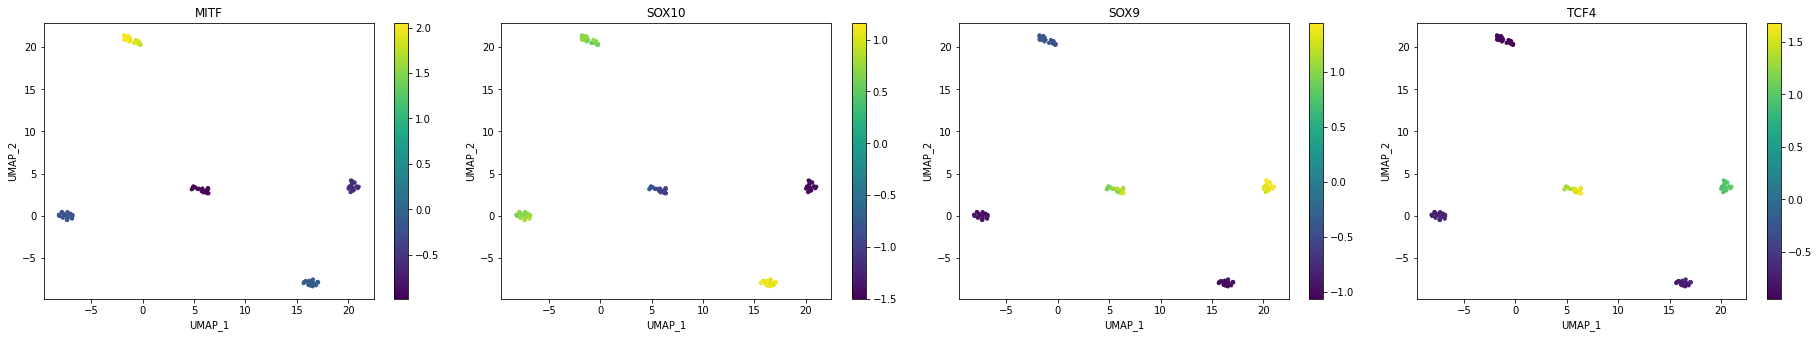

In [75]:
#os.mkdir(outDir+'DAGs')
from pycisTopic.clust_vis import *
plot_imputed_features(cistopic_obj,
                    reduction_name='UMAP',
                    imputed_data=gene_act,
                    features=['MITF', 'SOX10', 'SOX9', 'TCF4'], 
                    scale=True,
                    num_columns=4,
                    save= outDir + 'DAGs/example_best_DAGs.pdf')

How many DAGs do we have per cell type?

In [76]:
x = [print(x + ': '+ str(len(markers_dict[x]))) for x in markers_dict.keys()]

MM001: 2122
MM011: 2088
MM029: 2327
MM034: 2356
MM047: 2587


In [77]:
# Save
with open(outDir + 'DAGs/Gene_activity.pkl', 'wb') as f:
  pickle.dump(gene_act, f)
with open(outDir + 'DAGs/DAGs.pkl', 'wb') as f:
  pickle.dump(markers_dict, f)

## 8. Label transfer

In [6]:
# Load cisTopic object
import pickle
infile = open(outDir + 'toy_melanoma_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

Exploting the gene activity scores, we can transfer labels from a reference data set (e.g. scRNA-seq). As an example, we will transfer labels from a scRNA-seq data set with several melanoma cell lines. Note that MM034 is not included in this data set, so it will be labelled as a close cell line in the data set instead.

In [80]:
# Prepare RNA
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
path_to_loom = projDir + 'data/MM_SCENIC+_gene_based.loom'
loom = SCopeLoom.read_loom(path_to_loom)
metadata = get_metadata(loom)
expr_mat = loom.ex_mtx
expr_mat.dropna(inplace=True, axis=1)
rna_anndata = anndata.AnnData(X=expr_mat)
rna_anndata.obs = metadata
# Prepare ATAC
import pickle
infile = open(outDir + 'DAGs/Gene_activity.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
gene_act = pickle.load(infile)
infile.close()
atac_anndata = anndata.AnnData(X=gene_act.mtx.T, obs=pd.DataFrame(index=gene_act.cell_names), var=pd.DataFrame(index=gene_act.feature_names))
atac_anndata.obs = cistopic_obj.cell_data

The methods available for label transferring are: ingest' [from scanpy], 'harmony' [Korsunsky et al, 2019], 'bbknn' [Polański et al, 2020], 'scanorama' [Hie et al, 2019] and 'cca'. Except for ingest, these methods return a common coembedding and labels are inferred using the distances between query and refenrence cells as weights.

In [81]:
from pycisTopic.label_transfer import *
label_dict = label_transfer(rna_anndata,
                  atac_anndata,
                  labels_to_transfer = ['MMline'],
                  variable_genes = True,
                  methods = ['ingest', 'harmony', 'bbknn', 'scanorama', 'cca'],
                  return_label_weights = False,
                  _temp_dir= tmpDir + 'ray_spill')

2022-08-08 17:20:02,028 cisTopic     INFO     Normalizing RNA data
2022-08-08 17:20:05,463 cisTopic     INFO     Processing 1 query sample(s) using 1 cpu(s)


2022-08-08 17:20:08,240	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(label_transfer_ray pid=30915) 2022-08-08 17:20:11,847 cisTopic     INFO     Normalizing ATAC data from sample cisTopic


(label_transfer_ray pid=30915) /opt/venv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
(label_transfer_ray pid=30915)   view_to_actual(adata)


(label_transfer_ray pid=30915) 2022-08-08 17:20:18,680 cisTopic     INFO     Running integration with ingest


(label_transfer_ray pid=30915) /opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
(label_transfer_ray pid=30915)   [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


(label_transfer_ray pid=30915) 2022-08-08 17:20:46,274 cisTopic     INFO     Running integration with harmony
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,425 harmonypy    INFO     Iteration 1 of 10
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,504 harmonypy    INFO     Iteration 2 of 10
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,578 harmonypy    INFO     Iteration 3 of 10
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,606 harmonypy    INFO     Iteration 4 of 10
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,628 harmonypy    INFO     Iteration 5 of 10


(label_transfer_ray pid=30915) 2022-08-08 17:20:46,425 - harmonypy - INFO - Iteration 1 of 10
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,504 - harmonypy - INFO - Iteration 2 of 10
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,578 - harmonypy - INFO - Iteration 3 of 10
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,606 - harmonypy - INFO - Iteration 4 of 10
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,628 - harmonypy - INFO - Iteration 5 of 10


(label_transfer_ray pid=30915) 2022-08-08 17:20:46,652 harmonypy    INFO     Iteration 6 of 10
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,674 harmonypy    INFO     Iteration 7 of 10
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,696 harmonypy    INFO     Converged after 7 iterations
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,704 cisTopic     INFO     Running integration with bbknn


(label_transfer_ray pid=30915) 2022-08-08 17:20:46,652 - harmonypy - INFO - Iteration 6 of 10
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,674 - harmonypy - INFO - Iteration 7 of 10
(label_transfer_ray pid=30915) 2022-08-08 17:20:46,696 - harmonypy - INFO - Converged after 7 iterations


(label_transfer_ray pid=30915) 2022-08-08 17:20:49,535 cisTopic     INFO     Running integration with scanorama
(label_transfer_ray pid=30915) Found 995 genes among all datasets
(label_transfer_ray pid=30915) [[0.   0.96]
(label_transfer_ray pid=30915)  [0.   0.  ]]
(label_transfer_ray pid=30915) Processing datasets (0, 1)
(label_transfer_ray pid=30915) 2022-08-08 17:20:50,037 cisTopic     INFO     Running integration with cca


(label_transfer_ray pid=30915) /opt/venv/lib/python3.8/site-packages/scanorama/scanorama.py:237: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
(label_transfer_ray pid=30915)   adata = AnnData(datasets[i])
(label_transfer_ray pid=30915) /opt/venv/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
(label_transfer_ray pid=30915)   warnings.warn('Maximum number of iterations reached',


We can now add the annotations to our cisTopic object and visualize them in the cell-topic UMAP. Scanorama and harmony are the ones that work best.

In [82]:
label_dict_x=[label_dict[key] for key in label_dict.keys()]
label_pd = pd.concat(label_dict_x, axis=1, sort=False)
label_pd.index = cistopic_obj.cell_names
label_pd.columns = ['pycisTopic_' + x for x in label_pd.columns]
cistopic_obj.add_cell_data(label_pd, split_pattern = '-')

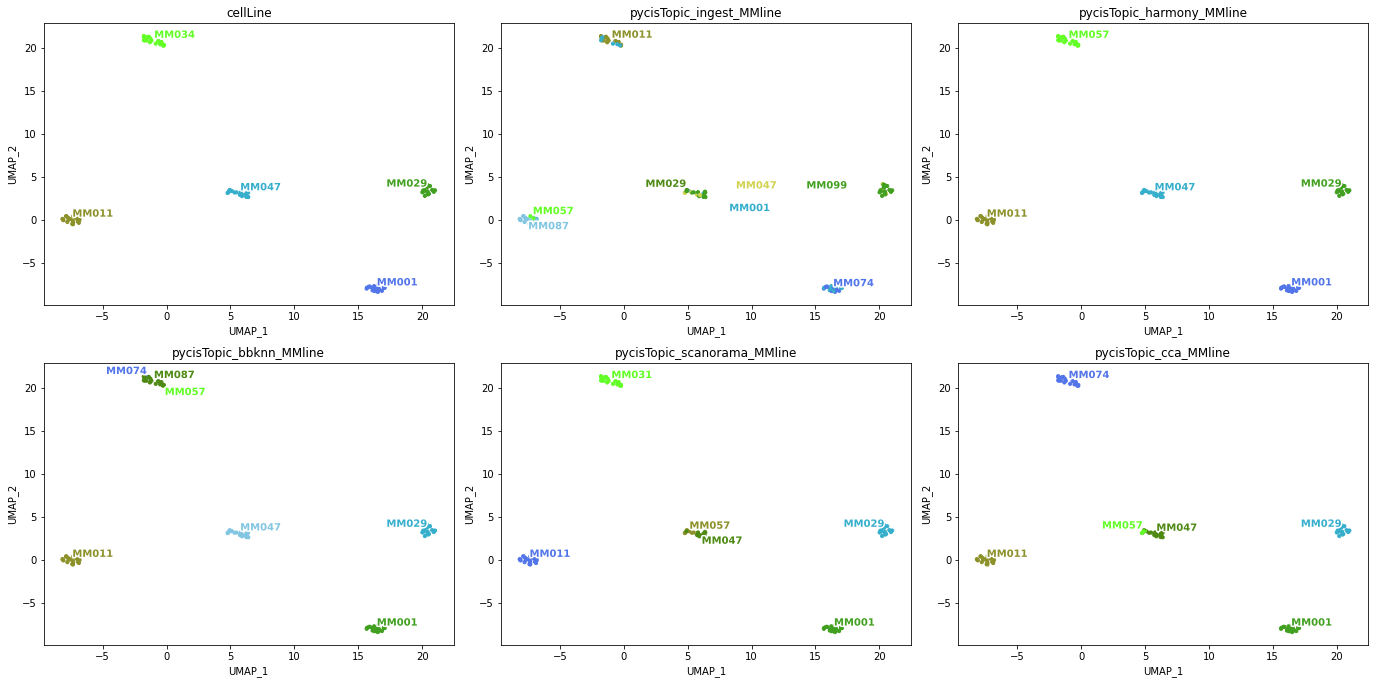

In [84]:
from pycisTopic.clust_vis import *
plot_metadata(cistopic_obj,
             reduction_name='UMAP',
             variables=['cellLine'] + label_pd.columns.to_list(),
             remove_nan=True,
             cmap=cm.viridis, 
             seed=555,
             num_columns=3,
             color_dictionary={},
             save= outDir + 'DAGs/label_transfer.pdf')

Ingest is the worst performing method in this data set.

In [85]:
# Save
with open(outDir + 'toy_melanoma_cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

## 9. Exporting to loom

We can now create loom files to further explore the results. There are two types of loom files:

* **Region accessibility**: These loom files include the imputed accessibility as matrix, topics as regulons and cell-topic distributions as AUC matrices. The imputed values, the cistopic object used for the imputation and the cell-topic and topic-region binarized distributions are required. Alternatively, we can also provide different clustering and the marker regions (DARs) per group per clustering.

* **Gene activity**: These loom files contain the gene activity as matrix, scRNA-seq derived regulons and their AUC values based on gene activity. The gene activity values, the cistopic object, and scRNA-seq derived regulons are required. Alternatively, we can also provide different clustering and the marker genes (DAGs) per group per clustering.

We will first load the data we need for the region accessibility loom files.

In [86]:
# Load cisTopic object
import pickle
infile = open(outDir + 'toy_melanoma_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Load imputed accessibility
import pickle
infile = open(outDir + 'DARs/Imputed_accessibility.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any 
imputed_acc_obj = pickle.load(infile)
infile.close()
# Load region binarized topics
import pickle
infile = open(outDir + 'topic_binarization/binarized_topic_region.pkl', 'rb')
binarized_topic_region = pickle.load(infile)
infile.close()
# Load cell binarized topics
import pickle
infile = open(outDir + 'topic_binarization/binarized_cell_topic.pkl', 'rb')
binarized_cell_topic = pickle.load(infile)
infile.close()
# Load DARs
import pickle
infile = open(outDir + 'DARs/DARs.pkl', 'rb')
DARs_dict = pickle.load(infile)
infile.close()

### 9a. Region accessibility

In [89]:
# Prepare DARs dict
cluster_markers = {'cellLine': DARs_dict}
# Export to loom
from pycisTopic.loom import *
#os.mkdir(outDir+'loom')
export_region_accessibility_to_loom(accessibility_matrix = imputed_acc_obj,
                  cistopic_obj = cistopic_obj, 
                  binarized_topic_region = binarized_topic_region,
                  binarized_cell_topic = binarized_cell_topic,
                  out_fname = outDir + 'loom/toy_melanoma_pycisTopic_region_accessibility.loom',
                  cluster_annotation = ['cellLine'],
                  cluster_markers = cluster_markers,
                  tree_structure = ('Toy_melanoma', 'pycisTopic'),
                  title = 'Tutorial - Region accessibility all',
                  nomenclature = "hg19") 

2022-08-08 17:24:39,871 cisTopic     INFO     Creating minimal loom
2022-08-08 17:24:41,108 cisTopic     INFO     Adding annotations
2022-08-08 17:24:41,526 cisTopic     INFO     Adding clusterings
2022-08-08 17:24:41,529 cisTopic     INFO     Adding markers
2022-08-08 17:24:42,848 cisTopic     INFO     Exporting


### 9b. Gene activity

In [92]:
# Load cisTopic object
import pickle
infile = open(outDir + 'toy_melanoma_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Get regulons
path_to_annotated_rna_loom = projDir + 'data/MM_SCENIC+_gene_based.loom'
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
regulons = get_regulons(loom)
# Get gene activity
import pickle
infile = open(outDir + 'DAGs/Gene_activity.pkl', 'rb') 
gene_act = pickle.load(infile)
infile.close()
# Get DAGs
import pickle
infile = open(outDir + 'DAGs/DAGs.pkl', 'rb')
DAGs_dict = pickle.load(infile)
infile.close()
cluster_markers = {'cellLine': DAGs_dict}
# Get metadata from high-quality loom file
#from pycisTopic.loom import *
cell_data = get_metadata(loom)
# Export
export_gene_activity_to_loom(gene_activity_matrix = gene_act,
                  cistopic_obj = cistopic_obj, 
                  regulons = regulons,
                  out_fname = outDir + 'loom/toy_melanoma_pycisTopic_gene_activity.loom',
                  cluster_annotation = ['cellLine'],
                  cluster_markers = cluster_markers,
                  tree_structure = ('Toy_melanoma', 'pycisTopic'),
                  title = 'Tutorial - Gene activity',
                  nomenclature = "hg19")

2022-08-08 17:26:29,579 cisTopic     INFO     Creating minimal loom


100%|██████████| 244/244 [00:02<00:00, 83.07it/s] 


2022-08-08 17:28:26,371 cisTopic     INFO     Adding annotations
2022-08-08 17:28:26,551 cisTopic     INFO     Adding clusterings
2022-08-08 17:28:26,558 cisTopic     INFO     Adding markers
2022-08-08 17:28:26,757 cisTopic     INFO     Exporting


## 10. Downstream analysis

### 10a. pyGREAT

pycisTopic provides a wrapper over GREAT (http://great.stanford.edu/public/html/; similar to rGREAT in R) to perform GO analysis on sets of regions. In this example we will perform this analysis on topic regions.

In [93]:
# Load region binarized topics
import pickle
infile = open(outDir + 'topic_binarization/binarized_topic_region.pkl', 'rb')
binarized_topic_region = pickle.load(infile)
infile.close()

In [94]:
import pyranges as pr
from pycistarget.utils import *
region_sets = {key: pr.PyRanges(region_names_to_coordinates(binarized_topic_region[key].index.tolist())) for key in binarized_topic_region.keys()}

In [95]:
from pycisTopic.pyGREAT import *
result = pyGREAT(region_sets, 'hg19', n_cpu=5, _temp_dir = tmpDir + 'ray_spill')

2022-08-08 17:29:23,578	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


Let's check topic 7 for example. This is a mesenchymal-like topic and we find GO terms related to stress and extracellular matrix organization:

In [96]:
result['Topic7']['GO Biological Process'][0:10]

,Ontology,ID,Desc,BinomRank,BinomP,BinomBonfP,BinomFdrQ,RegionFoldEnrich,ExpRegions,ObsRegions,...,HyperBonfP,HyperFdrQ,GeneFoldEnrich,ExpGenes,ObsGenes,TotalGenes,GeneSetCov,TermCov,Regions,Genes
0,GO Biological Process,GO:0006950,response to stress,1,3.762560e-61,4.945885e-57,4.945885e-57,1.422282e+0,1.229714e+3,1749,...,1.147141e-6,6.408609e-9,1.186234e+0,7.679764e+2,911,3265,2.088013e-1,2.790199e-1,"chr10:101534266-101545969,chr10:101723549-1017...","ABCA1,ABCC2,ABHD2,ABL1,ABL2,ACTG1,ACTN4,ACTR5,..."
1,GO Biological Process,GO:0030198,extracellular matrix organization,2,5.028628e-56,6.610132e-52,3.305066e-52,2.448981e+0,1.588415e+2,389,...,2.130413e-9,1.902154e-11,1.804062e+0,7.150531e+1,129,304,2.956681e-2,4.243421e-1,"chr10:102819857-102822587,chr10:105667330-1056...","ABI3BP,ADAM10,ADAM12,ADAM19,ADAMTS20,ADAMTS5,A..."
2,GO Biological Process,GO:0043062,extracellular structure organization,3,7.404368e-56,9.733042e-52,3.244347e-52,2.445010e+0,1.590995e+2,389,...,2.846151e-9,2.453579e-11,1.798147e+0,7.174053e+1,129,305,2.956681e-2,4.229508e-1,"chr10:102819857-102822587,chr10:105667330-1056...","ABI3BP,ADAM10,ADAM12,ADAM19,ADAMTS20,ADAMTS5,A..."
3,GO Biological Process,GO:0009966,regulation of signal transduction,4,1.274500e-52,1.675330e-48,4.188326e-49,1.345830e+0,1.444462e+3,1944,...,1.453971e-20,8.552771e-22,1.313747e+0,7.124657e+2,936,3029,2.145313e-1,3.090129e-1,"chr10:101723549-101724795,chr10:101726408-1017...","ABCA1,ABCA7,ABL1,ABR,ACTN4,ACVR1,ADA,ADAM17,AD..."
4,GO Biological Process,GO:0048583,regulation of response to stimulus,5,7.434707e-49,9.772922e-45,1.954584e-45,1.286047e+0,1.744881e+3,2244,...,2.376462e-15,6.093493e-17,1.235421e+0,9.098110e+2,1124,3868,2.576209e-1,2.905895e-1,"chr10:101723549-101724795,chr10:101726408-1017...","ABCA1,ABCA7,ABL1,ABR,ACOX2,ACTG1,ACTN4,ACVR1,A..."
5,GO Biological Process,GO:0048519,negative regulation of biological process,6,2.960564e-46,3.891661e-42,6.486102e-43,1.235537e+0,2.105157e+3,2601,...,1.679393e-27,2.099242e-28,1.268681e+0,1.111390e+3,1410,4725,3.231721e-1,2.984127e-1,"chr10:104363683-104365181,chr10:104386970-1043...","AARS,ABCA1,ABCA5,ABCA7,ABHD17C,ABHD2,ABL1,ABR,..."
6,GO Biological Process,GO:0048523,negative regulation of cellular process,7,1.903390e-45,2.502006e-41,3.574295e-42,1.244671e+0,1.999725e+3,2489,...,1.021488e-25,8.512404e-27,1.272924e+0,1.037768e+3,1321,4412,3.027733e-1,2.994107e-1,"chr10:104363683-104365181,chr10:104386970-1043...","AARS,ABCA1,ABCA5,ABCA7,ABHD2,ABL1,ABR,ACE,ACTN..."
7,GO Biological Process,GO:0048518,positive regulation of biological process,8,2.846480e-45,3.741698e-41,4.677122e-42,1.207542e+0,2.366792e+3,2858,...,6.906195e-28,1.151033e-28,1.245298e+0,1.274394e+3,1587,5418,3.637405e-1,2.929125e-1,"chr10:104363683-104365181,chr10:104386970-1043...","AADAC,ABCA1,ABCA7,ABCC4,ABHD17C,ABI3BP,ABL1,AB..."
8,GO Biological Process,GO:0048522,positive regulation of cellular process,9,1.075364e-44,1.413566e-40,1.570629e-41,1.220749e+0,2.210939e+3,2699,...,3.243523e-26,2.948658e-27,1.255928e+0,1.153729e+3,1449,4905,3.321109e-1,2.954128e-1,"chr10:104363683-104365181,chr10:104386970-1043...","AADAC,ABCA1,ABCA7,ABCC4,ABL1,ABL2,ABLIM3,ABR,A..."
9,GO Biological Process,GO:0050896,response to stimulus,10,1.446331e-44,1.901202e-40,1.901202e-41,1.166676e+0,2.845691e+3,3320,...,1.847655e-11,2.566187e-13,1.124843e+0,1.810919e+3,2037,7699,4.668806e-1,2.645798e-1,"chr10:101151097-101153782,chr10:101534266-1015...","AADAC,AANAT,ABCA1,ABCA7,ABCC1,ABCC2,ABCC3,ABCC..."


In topic 8, a melanocyte-like topic, we find pigmentation terms: 

In [97]:
result['Topic8']['GO Biological Process'][0:10]

,Ontology,ID,Desc,BinomRank,BinomP,BinomBonfP,BinomFdrQ,RegionFoldEnrich,ExpRegions,ObsRegions,...,HyperBonfP,HyperFdrQ,GeneFoldEnrich,ExpGenes,ObsGenes,TotalGenes,GeneSetCov,TermCov,Regions,Genes
0,GO Biological Process,GO:0006810,transport,1,2.691050e-18,3.537385e-14,3.537385e-14,1.240217e+0,8.974233e+2,1113,...,4.733396e-5,2.958373e-6,1.175650e+0,7.213030e+2,848,4214,2.670866e-1,2.012340e-1,"chr10:100005147-100008839,chr10:100123397-1001...","A1BG,AAAS,ABCA8,ABCB10,ABCB5,ABCC5,ABCG8,ABI1,..."
1,GO Biological Process,GO:0046907,intracellular transport,2,3.402477e-18,4.472556e-14,2.236278e-14,1.524559e+0,2.774573e+2,423,...,4.627834e-3,1.006051e-4,1.302232e+0,2.242304e+2,292,1310,9.196850e-2,2.229008e-1,"chr10:102065902-102068762,chr10:11098585-11102...","AAAS,ACACB,AKAP12,AKAP13,AKAP6,AKT2,ANK1,ANK2,..."
2,GO Biological Process,GO:0051234,establishment of localization,3,1.569173e-17,2.062678e-13,6.875593e-14,1.229609e+0,9.214308e+2,1133,...,9.749439e-5,4.642590e-6,1.168982e+0,7.399604e+2,865,4323,2.724409e-1,2.000925e-1,"chr10:100005147-100008839,chr10:100123397-1001...","A1BG,AAAS,ABCA8,ABCB10,ABCB5,ABCC5,ABCG8,ABI1,..."
3,GO Biological Process,GO:0043473,pigmentation,4,2.698505e-15,3.547185e-11,8.867962e-12,2.652862e+0,3.241782e+1,86,...,5.678607e-3,1.158899e-4,2.286080e+0,1.574748e+1,36,92,1.133858e-2,3.913043e-1,"chr10:100226668-100228206,chr10:100269093-1002...","AP3B1,ATP6AP2,BBS5,BCL2,BLOC1S2,C10orf11,DCT,D..."
4,GO Biological Process,GO:0051179,localization,5,1.419648e-14,1.866127e-10,3.732255e-11,1.168966e+0,1.165988e+3,1363,...,3.422435e-8,1.140812e-8,1.180480e+0,8.970928e+2,1059,5241,3.335433e-1,2.020607e-1,"chr10:100005147-100008839,chr10:100123397-1001...","A1BG,AAAS,ABCA8,ABCB10,ABCB5,ABCC5,ABCG8,ABI1,..."
5,GO Biological Process,GO:0051641,cellular localization,6,5.693101e-14,7.483581e-10,1.247264e-10,1.320897e+0,4.769487e+2,630,...,5.648709e-4,2.172580e-5,1.254992e+0,3.466157e+2,435,2025,1.370079e-1,2.148148e-1,"chr10:102065902-102068762,chr10:103824482-1038...","AAAS,ACACB,AHI1,AKAP12,AKAP13,AKAP6,AKT2,AMN,A..."
6,GO Biological Process,GO:0051649,establishment of localization in cell,7,1.440987e-13,1.894177e-9,2.705968e-10,1.387513e+0,3.430598e+2,476,...,6.570524e-2,7.916294e-4,1.246695e+0,2.606893e+2,325,1523,1.023622e-1,2.133946e-1,"chr10:102065902-102068762,chr10:11098585-11102...","AAAS,ACACB,AKAP12,AKAP13,AKAP6,AKT2,ANK1,ANK2,..."
7,GO Biological Process,GO:0016192,vesicle-mediated transport,8,1.806147e-13,2.374180e-9,2.967725e-10,1.369048e+0,3.688694e+2,505,...,1.918225e-1,1.809646e-3,1.223034e+0,2.820853e+2,345,1648,1.086614e-1,2.093447e-1,"chr10:100005147-100008839,chr10:100123397-1001...","A1BG,ABI1,ABL1,ACTG1,ADAM10,ADAM8,ADRBK2,AGA,A..."
8,GO Biological Process,GO:0086030,adrenergic receptor signaling pathway involved...,9,1.255223e-12,1.649991e-8,1.833323e-9,3.323557e+1,3.008824e-1,10,...,1.000000e+0,8.217704e-1,5.842205e+0,1.711683e-1,1,1,3.149606e-4,1.000000e+0,"chr14:93371313-93373991,chr14:93424817-9342602...",CHGA
9,GO Biological Process,GO:0044765,single-organism transport,10,2.753750e-12,3.619804e-8,3.619804e-9,1.266793e+0,5.628386e+2,713,...,1.235203e-2,2.093564e-4,1.198994e+0,4.320287e+2,518,2524,1.631496e-1,2.052298e-1,"chr10:101491391-101493065,chr10:102065902-1020...","A1BG,AAAS,ABCA8,ABCB5,ABCG8,ABI1,ABL1,ACACB,AC..."


We can also retrieve regions linked to a specific GO term:

In [98]:
signatures_dict = {}
signatures_dict['EMT'] = get_region_signature(result, 'Topic7', 'GO Biological Process', 'extracellular matrix organization')
signatures_dict['Pigmentation'] = get_region_signature(result, 'Topic8', 'GO Biological Process', 'pigmentation')

In [99]:
# Save
os.mkdir(outDir+'pyGREAT')
with open(outDir + 'pyGREAT/pyGREAT_dict.pkl', 'wb') as f:
  pickle.dump(result, f)

### 10b. Signature enrichment

Given a set of signatures (e.g. Chip-seq peaks, bulk peaks, ...), pycisTopic allows to calculate their enrichment on cells or topics. In this example, we will use the GO signatures from pyGREAT as example.

In [100]:
# Load GREAT results
import pickle
infile = open(outDir + 'pyGREAT/pyGREAT_dict.pkl', 'rb')
result = pickle.load(infile)
infile.close()
# Load signatures
from pycisTopic.pyGREAT import *
signatures_dict = {}
signatures_dict['EMT'] = get_region_signature(result, 'Topic7', 'GO Biological Process', 'extracellular matrix organization')
signatures_dict['Pigmentation'] = get_region_signature(result, 'Topic8', 'GO Biological Process', 'pigmentation')

In [101]:
# Load imputed accessibility
import pickle
infile = open(outDir + 'DARs/Imputed_accessibility.pkl', 'rb') 
imputed_acc_obj = pickle.load(infile)
infile.close()

In [103]:
# Load cisTopic object
import pickle
infile = open(outDir + 'toy_melanoma_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [106]:
from pycisTopic.signature_enrichment import *
imputed_acc_obj.mtx = scipy.sparse.csr_matrix(imputed_acc_obj.mtx)
ranking = imputed_acc_obj.make_rankings()
signature_scores = signature_enrichment(ranking, signatures_dict, n_cpu=5)

We can add now the enrichment scores to our cisTopic object as metadata and plot them:

In [107]:
cistopic_obj.add_cell_data(signature_scores, split_pattern = '-')

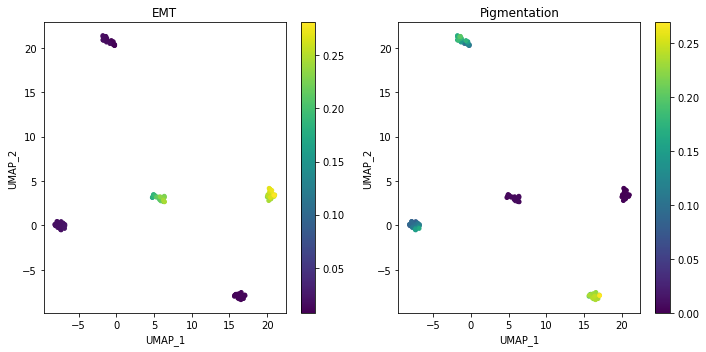

In [108]:
from pycisTopic.clust_vis import *
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['EMT', 'Pigmentation'], 
                 target='cell', num_columns=2,
                 text_size=24,
                 dot_size=15,
                 figsize=(10,5))

We find the pigmentation regions in melanocyte-like cell lines, while the EMT term in mesenchymal-like cell lines.